# Does this person make over 50k$ a year?

AI Black Belt - Yellow (May 2019).

---

## Census data

In this notebook we will consider Census data which gathers socio-demographic information about individuals. From the features describing a person, we will build a classifier that predicts whether the corresponding person earns over 50k$ a year.

In [1]:
import pandas as pd 
import numpy as np

In [2]:
df = pd.read_csv("data/adult.csv", index_col=0)
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
df.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


<div class="alert alert-success">

<b>EXERCISE</b>:

Experiment with visualizing the data. Can you find out which features influence the income the most?

</div>

In [4]:
df["income_bin"] = df["income"] == " >50K"

In [5]:
df.groupby("age")["income_bin"].mean().plot()

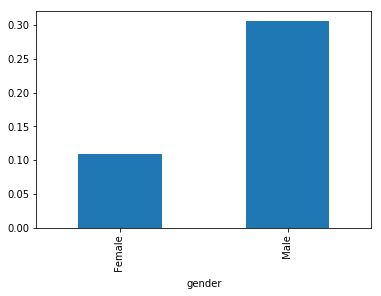

In [6]:
df.groupby("gender")["income_bin"].mean().plot(kind="bar")

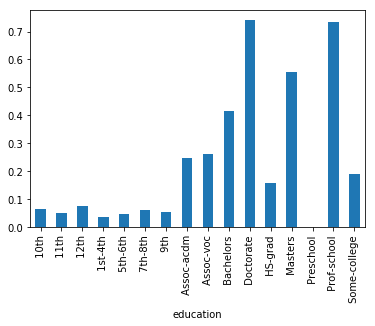

In [7]:
df.groupby("education")["income_bin"].mean().plot(kind="bar")

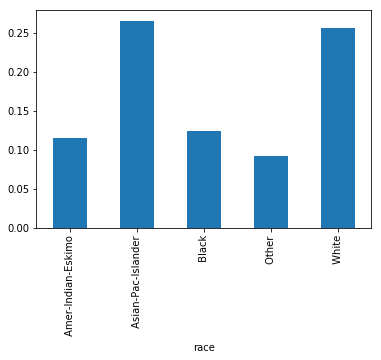

In [8]:
df.groupby("race")["income_bin"].mean().plot(kind="bar")

In [28]:
df.corr()

,age,education-num,capital-gain,capital-loss,hours-per-week,income_bin
age,1.000000,0.036527,0.077674,0.057775,0.068756,0.234037
education-num,0.036527,1.000000,0.122630,0.079923,0.148123,0.335154
capital-gain,0.077674,0.122630,1.000000,-0.031615,0.078409,0.223329
capital-loss,0.057775,0.079923,-0.031615,1.000000,0.054256,0.150526
hours-per-week,0.068756,0.148123,0.078409,0.054256,1.000000,0.229689
income_bin,0.234037,0.335154,0.223329,0.150526,0.229689,1.000000


<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
    <li>Make a dataframe <code>X</code> that contains all but the <code>income</code> column.</li>
    <li>Make a series <code>y</code> that contains the <code>income</code> column only.</li>
</ul>
</div>

In [9]:
X = df.drop(["income"], axis=1)
y = df["income"]

## Preprocessing

### Missing values

Some columns have missing values, encoded as <code>'?'</code> in the original data.

In [10]:
X["native-country"].value_counts()[:10]

 United-States    29170
 Mexico             643
 ?                  583
 Philippines        198
 Germany            137
 Canada             121
 Puerto-Rico        114
 El-Salvador        106
 India              100
 Cuba                95
Name: native-country, dtype: int64

For convenience, we will replace them with NaNs.

In [11]:
X = X.replace([" ?", "?"], np.nan)

In [12]:
X.isna().sum()

age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
gender               0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income_bin           0
dtype: int64

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 14 columns):
age               32561 non-null int64
workclass         30725 non-null object
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
gender            32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    31978 non-null object
income_bin        32561 non-null bool
dtypes: bool(1), int64(5), object(8)
memory usage: 3.5+ MB


In [14]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="most_frequent")

In [15]:
X["workclass"] = imp.fit_transform(X["workclass"].values.reshape(-1, 1)).flatten()
X["occupation"] = imp.fit_transform(X["occupation"].values.reshape(-1, 1)).flatten()
X["native-country"] = imp.fit_transform(X["native-country"].values.reshape(-1, 1)).flatten()

In [16]:
X.isna().sum()

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
gender            0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income_bin        0
dtype: int64

### Converting categorical variables

As shown below, not all columns are numerical. Those which aren't must be converted before being ingested by a Scikit-Learn machine learning algorithm. 

In [17]:
categories = X.dtypes == object
categories

age               False
workclass          True
education          True
education-num     False
marital-status     True
occupation         True
relationship       True
race               True
gender             True
capital-gain      False
capital-loss      False
hours-per-week    False
native-country     True
income_bin        False
dtype: bool

Categorical variables can be encoded into numerical values by associating a unique number to each unique value.

In [18]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
tf = make_column_transformer((OrdinalEncoder(), categories), remainder="passthrough")
X_new = tf.fit_transform(X)

In [19]:
X_new.shape

(32561, 14)

In [20]:
X_new[0]

array([6.0, 9.0, 4.0, 0.0, 1.0, 4.0, 1.0, 38.0, 39, 13, 2174, 0, 40,
       False], dtype=object)

This transformation implicitly assumes an arbitrary ordering between values. Depending on the downward machine learning algorithm, this might lead to good or bad results.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=0)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="lbfgs", C=0.1)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

/home/gilles/anaconda3/envs/blackbelt/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.8555460017196904

An alternative transformation is to encode categorical variables as one-hot binary vectors.

In [22]:
from sklearn.preprocessing import OneHotEncoder
tf = make_column_transformer((OneHotEncoder(sparse=False), categories), remainder="passthrough")
X_new = tf.fit_transform(X)

In [23]:
X_new.shape

(32561, 105)

In [24]:
print(X_new[0])

[0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 39 13 2174 0 40 False]


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=0)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="lbfgs", C=0.1)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

/home/gilles/anaconda3/envs/blackbelt/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9450927404495763

### Scaling

Some algorithms, such as linear models or KNNs, are sensitive to the scale of the features. It is often critical to rescale feature values to a fixed range.

In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
tf = make_column_transformer((OneHotEncoder(sparse=False), categories), 
                             (StandardScaler(), ~categories),
                             remainder="passthrough")
X_new = tf.fit_transform(X)

/home/gilles/anaconda3/envs/blackbelt/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/gilles/anaconda3/envs/blackbelt/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=0)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="lbfgs", C=0.1)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

1.0

## Model comparison

<div class="alert alert-success">

<b>EXERCISE</b>:

Compare the performance of <code>LogisticRegression</code>, <code>KNeighborsClassifier</code>, <code>DecisionTreeClassifier</code> and <code>GaussianNB</code>.

</div>

<div class="alert alert-success">

<b>EXERCISE</b>:

Observe how preprocessing might change your results above. For example, switch to ordinal encoding of the categorical variables.
</ul>
</div>